In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
import seaborn as sns

#import pydicom
import time
from functools import partial
import gc
import operator 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
from sklearn.model_selection import KFold
from tqdm import tqdm, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
%load_ext autoreload
%autoreload 2
%matplotlib inline
from skimage.io import imread,imshow
from helper import *
import helper
import torchvision.models as models
from torch.optim import Adam
from defenitions import *

/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
SEED = 8153
device=device_by_name("Tesla")
#device=device_by_name("RTX")
#device=device_by_name("1060")
torch.cuda.set_device(device)
#device = "cpu"
sendmeemail=Email_Progress(my_gmail,my_pass,to_email,'Densenet161-Copy2-2 results')

In [3]:
def get_submission(test_df,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_any','Label':torch.sigmoid(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [4]:
def get_submission_ids(image_ids,pred,do_sigmoid=True):
    if do_sigmoid:
        func = lambda x:torch.sigmoid(x)
    else:
        func = lambda x:x
    epidural_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_epidural','Label':func(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_intraparenchymal','Label':func(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_intraventricular','Label':func(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_subarachnoid','Label':func(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_subdural','Label':func(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_any','Label':func(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [5]:
old_train_df = pd.read_csv(data_dir+'train.csv')
old_train_df.shape
old_train_df=old_train_df[~old_train_df.PatientID.isin(bad_images)].reset_index(drop=True)
old_train_df=old_train_df.drop_duplicates().reset_index(drop=True)
old_train_df.shape
old_train_df.head()

train_df = pd.read_csv(data_dir+'train_stage2.csv')
train_df.shape


old_test_df = pd.read_csv(data_dir+'test.csv')
old_test_df.head()
assert old_test_df.shape[0]+old_train_df.shape[0]==train_df.shape[0]


(674252, 15)

(674252, 15)

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


(752797, 15)

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,SeriesI,PID,StudyI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,28fbab7eb,0.5,0.5,0.5,0.5,0.5,0.5,ebfd7e4506,cf1b6b11,93407cadbb,30,80,158.458000,-125.0,-135.598000
1,877923b8b,0.5,0.5,0.5,0.5,0.5,0.5,6d95084e15,ad8ea58f,a337baa067,30,80,138.729050,-125.0,-101.797981
2,a591477cb,0.5,0.5,0.5,0.5,0.5,0.5,8e06b2c9e0,ecfb278b,0cfe838d54,30,80,60.830002,-125.0,-133.300003
3,42217c898,0.5,0.5,0.5,0.5,0.5,0.5,e800f419cf,e96e31f4,c497ac5bad,30,80,55.388000,-125.0,-146.081000
4,a130c4d2f,0.5,0.5,0.5,0.5,0.5,0.5,faeb7454f3,69affa42,854e4fbc01,30,80,33.516888,-125.0,-118.689819


In [6]:
test_df = pd.read_csv(data_dir+'test_stage2.csv')
test_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,SeriesI,PID,StudyI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,0fbf6a978,0.5,0.5,0.5,0.5,0.5,0.5,48eaa460c6,3556ae0e,3710aff1c5,40,100,37.690857,-125.0,-117.830185
1,d62ec3412,0.5,0.5,0.5,0.5,0.5,0.5,389cec2e11,c667d610,8e38d86ede,"['00036', '00036']","['00080', '00080']",762.200043,-66.0,-10.000000
2,cb544194b,0.5,0.5,0.5,0.5,0.5,0.5,a6ebe3ca4f,9389d3b6,7040866911,"['00036', '00036']","['00080', '00080']",818.400024,-105.0,6.000000
3,0d62513ec,0.5,0.5,0.5,0.5,0.5,0.5,01c388cfe3,79cdc6e4,07c298b5be,30,80,31.857132,-125.0,-112.984024
4,fc45b2151,0.5,0.5,0.5,0.5,0.5,0.5,d16ad143cb,39eb6eb6,6a15b35eae,"['00036', '00036']","['00080', '00080']",424.099976,-102.5,14.500000


In [7]:
def my_loss(y_pred,y_true,weights):
    window=(y_true>=0).to(torch.float)
    loss = (F.binary_cross_entropy_with_logits(y_pred,y_true,reduction='none')*window*weights.expand_as(y_true)).mean()/(window.mean()+1e-7)
    return loss

In [8]:
class Metric():
    def __init__(self,weights,k=0.03):
        self.weights=weights
        self.k=k
        self.zero()
        
    def zero(self):
        self.loss_sum=0.
        self.loss_count=0.
        self.lossf=0.
        
    def calc(self,y_pred,y_true,prefix=""):
        window=(y_true>=0).to(torch.float)
        loss = (F.binary_cross_entropy_with_logits(y_pred,y_true,reduction='none')*window*self.weights.expand_as(y_true)).mean()/(window.mean()+1e-5)
        self.lossf=self.lossf*(1-self.k)+loss*self.k
        self.loss_sum=self.loss_sum+loss*window.sum()
        self.loss_count=self.loss_count+window.sum()
        return({prefix+'mloss':self.lossf})    
        
    def calc_sums(self,prefix=""):
        return({prefix+'mloss_tot':self.loss_sum/self.loss_count})    



In [9]:
#features=(features-features.mean())/features.std()

In [10]:
class ResModel(nn.Module):
    def __init__(self,in_size):
        super(ResModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 64, (9,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(64)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(64, 64, 7, padding=3)
        self.bn1=torch.nn.BatchNorm1d(64)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(192, 6, 3, padding=1)
        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x0 = self.relu0(x)
        x = self.conv1d1(x0)
        x = self.bn1(x)
        x1 = self.relu1(x)
        x = torch.cat([x0,x1],1)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x2 = self.relu2(x)
        x = torch.cat([x0,x1,x2],1)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [11]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (5,2208), padding=(2,0))
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 6, 1)

        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.relu0(x)
        out = self.conv1d1(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [12]:
class ResModelPool(nn.Module):
    def __init__(self,in_size):
        super(ResModelPool, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 64, (9,in_size),stride=(1,in_size), padding=(4,0))
        self.bn0=torch.nn.BatchNorm1d(64)
#        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(64, 64, 7, padding=3)
        self.bn1=torch.nn.BatchNorm1d(64)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 5, padding=2)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(192, 6, 3, padding=1)
        
        
    def forward(self, x):
        x=x.unsqueeze(1)
        x = self.conv2d1(x)
        x=F.max_pool2d(x,kernel_size=(1,x.shape[-1])).squeeze(-1)        
        x0 = self.bn0(x)
#        x0 = self.relu0(x)
        x = self.conv1d1(x0)
        x = self.bn1(x)
        x1 = self.relu1(x)
        x = torch.cat([x0,x1],1)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x2 = self.relu2(x)
        x = torch.cat([x0,x1,x2],1)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [13]:
multi=3
model_names=['se_resnext101_32x4d',
             'se_resnext101_32x4d',
             'Densenet161_3',
             'Densenet169_3',
             'se_resnet101',
             'se_resnet101',
             'se_resnet101']
#types=['features_test','features_test','features_test','features_test','features_test','features_test','features_test','features_test']
versions=['classifier_splits',
          'new_splits',
          'classifier_splits',
          'classifier_splits',
          'classifier_splits',
          'new_splits',
          'new_splits_focal']
num_splits=[3,5,3,3,3,5,5]
seeds=[8153,432,8153,8153,8153,432,432]
for model_name,version_,n,SEED in zip(model_names,versions,num_splits,seeds):
    type_='features_test_stage2'
    for num_split in tqdm_notebook(range(n)):
        pred_list=[]
        print(model_name,version_,type_,num_split) 
        pickle_file=open(outputs_dir+outputs_format.format(model_name,version_,type_,num_split),'rb')
        features=pickle.load(pickle_file)
        pickle_file.close()
        features=features.reshape(features.shape[0]//8,8,-1)
        print(features.shape)
        model=ResModelPool(features.shape[-1])
        version=version_+'_fullhead_resmodel_pool2_stage2_{}'.format(multi)

        model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))

        valid_dataset=FullHeadDataset(test_df,
                                      test_df.SeriesI.unique(),
                                      features,
                                      'SeriesI',
                                      'ImagePositionZ',
                                      multi =4)

        win_dataset=FullHeadDataset(test_df,
                                      test_df.SeriesI.unique(),
                                      features,
                                      'SeriesI',
                                      'ImagePositionZ',
                                       target_columns=hemorrhage_types)
        win_list=[]
        dl = D.DataLoader(win_dataset,batch_size=128,num_workers=16)
        for _,win in tqdm_notebook(dl):
            win_list.append(win.reshape(win.shape[0]*win.shape[1],-1))    
        wins = torch.cat(win_list,0).sum(1)>=0
        wins.sum()
        for i in tqdm_notebook(range(32),leave=False):
            pr = model_run(model,valid_dataset,do_apex=False,batch_size=128)
            pred_list.append(pr.reshape(pr.shape[0]*pr.shape[1],-1)[wins])
        pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'test_pred_ensemble',num_split),'wb')
        pickle.dump(pred_list,pickle_file,protocol=4)
        pickle_file.close()


se_resnext101_32x4d classifier_splits features_test_stage2 0
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnext101_32x4d classifier_splits features_test_stage2 1
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnext101_32x4d classifier_splits features_test_stage2 2
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnext101_32x4d new_splits features_test_stage2 0
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnext101_32x4d new_splits features_test_stage2 1
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnext101_32x4d new_splits features_test_stage2 2
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnext101_32x4d new_splits features_test_stage2 3
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnext101_32x4d new_splits features_test_stage2 4
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

Densenet161_3 classifier_splits features_test_stage2 0
torch.Size([121232, 8, 552])


<All keys matched successfully>

tensor(121232)

Densenet161_3 classifier_splits features_test_stage2 1
torch.Size([121232, 8, 552])


<All keys matched successfully>

tensor(121232)

Densenet161_3 classifier_splits features_test_stage2 2
torch.Size([121232, 8, 552])


<All keys matched successfully>

tensor(121232)

Densenet169_3 classifier_splits features_test_stage2 0
torch.Size([121232, 8, 208])


<All keys matched successfully>

tensor(121232)

Densenet169_3 classifier_splits features_test_stage2 1
torch.Size([121232, 8, 208])


<All keys matched successfully>

tensor(121232)

Densenet169_3 classifier_splits features_test_stage2 2
torch.Size([121232, 8, 208])


<All keys matched successfully>

tensor(121232)

se_resnet101 classifier_splits features_test_stage2 0
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnet101 classifier_splits features_test_stage2 1
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnet101 classifier_splits features_test_stage2 2
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnet101 new_splits features_test_stage2 0
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnet101 new_splits features_test_stage2 1
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnet101 new_splits features_test_stage2 2
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnet101 new_splits features_test_stage2 3
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnet101 new_splits features_test_stage2 4
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnet101 new_splits_focal features_test_stage2 0
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnet101 new_splits_focal features_test_stage2 1
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnet101 new_splits_focal features_test_stage2 2
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnet101 new_splits_focal features_test_stage2 3
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

se_resnet101 new_splits_focal features_test_stage2 4
torch.Size([121232, 8, 256])


<All keys matched successfully>

tensor(121232)

In [44]:
pred_list=[]
model_names=['se_resnext101_32x4d',
             'se_resnext101_32x4d',
             'Densenet161_3',
             'Densenet169_3',
             'se_resnet101',
             'se_resnet101',
             'se_resnet101']
#types=['features_test','features_test','features_test','features_test','features_test','features_test','features_test','features_test']
versions=['classifier_splits',
          'new_splits',
          'classifier_splits',
          'classifier_splits',
          'classifier_splits',
          'new_splits',
          'new_splits_focal']
num_splits=[3,5,3,3,3,5,5]
for model_name,version_,n_splits in zip(model_names,versions,num_splits):
    for num_split in range(n_splits):
        version=version_+'_fullhead_resmodel_pool2_stage2_3'
        pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'test_pred_ensemble',num_split),'rb')
        pred_list.extend( pickle.load(pickle_file))
        pickle_file.close()


In [45]:
len(pred_list)
pred=torch.sigmoid(torch.cat([p[None] for p in pred_list],0)).mean(0)
pred.shape

864

torch.Size([121232, 6])

In [46]:
pickle_file=open(outputs_dir+'ensemble_test_image_ids_stage2.pkl','rb')
image_ids = pickle.load(pickle_file)   
pickle_file.close()

In [32]:
submission_df=get_submission_ids(image_ids,pred,do_sigmoid=False)
submission_df.head(12)
submission_df.shape


,ID,Label
0,ID_000000e27_any,9.501273e-04
1,ID_000000e27_epidural,4.105167e-05
2,ID_000000e27_intraparenchymal,3.959713e-04
3,ID_000000e27_intraventricular,3.313437e-05
4,ID_000000e27_subarachnoid,2.073304e-04
5,ID_000000e27_subdural,3.489370e-04
6,ID_000009146_any,6.613446e-05
7,ID_000009146_epidural,8.478917e-06
8,ID_000009146_intraparenchymal,4.919742e-06
9,ID_000009146_intraventricular,3.850217e-07


(727392, 2)

In [33]:
sub = pd.read_csv('/media/hd/notebooks/data/RSNA/submissions/submission_stage2_2.csv')

In [34]:
F.binary_cross_entropy(torch.tensor(submission_df.Label.values,dtype=torch.float),
                       torch.tensor(sub.Label.values>0.5,dtype=torch.float))

tensor(0.5039)

In [49]:
res_df=pd.DataFrame(data=pred.numpy(),columns=hemorrhage_types)

In [51]:
res_df['PatientID']=image_ids

In [52]:
res_df=res_df.merge(test_df[['PatientID','SeriesI','ImagePositionZ']],on='PatientID')

In [53]:
positive_id=res_df[res_df['any']>0.5].SeriesI.unique()

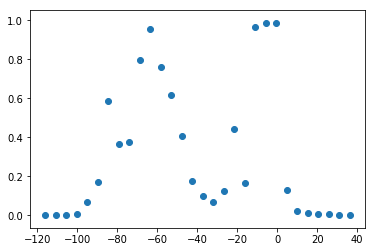

In [67]:
k=452
plt.scatter(res_df[res_df.SeriesI ==positive_id[k] ].ImagePositionZ,res_df[res_df.SeriesI ==positive_id[k] ]['any'])